## Data Exploration

In [1]:

s3_data ="s3://aegovan-data/human_output/human_keyinteractions.json"
s3_annotations ="s3://aegovan-data/input_data_pubtator_annotated.txt"
human_idmapping_dat = "/Users/aeg/Downloads/HUMAN_9606_idmapping.dat"

In [2]:
import boto3

def download_single_file(bucket_name_path, local_path):
    index = bucket_name_path.find("://")

    # remove the s3:// if present
    if index > -1:
        bucket_name_path = bucket_name_path[index + 3:]

    key_start_index = bucket_name_path.find("/")
    bucket_name = bucket_name_path
    key = "/"
    if key_start_index > -1:
        bucket_name = bucket_name_path[0:key_start_index]
        key = bucket_name_path[key_start_index + 1:]
        
    client = boto3.resource('s3')
    client.Bucket(bucket_name).download_file(key, local_path)


In [3]:
data_file="input_data.json"
annotations_file="input_data_annotations.txt"

In [4]:
download_single_file(s3_data, data_file)

In [5]:
download_single_file(s3_annotations, annotations_file)

In [6]:

import pandas as pd

data = pd.read_json(data_file)

print("Total number of records: {}".format(data.shape[0]))

Total number of records: 3381


In [7]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', 100)

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

## Preliminary data transformations

In [8]:
#TODO: Fix data format
data["pubmedId"] = data["pubmedId"].astype(str)
data["interactionId"] = data["interactionId"].astype(str)
data["isValid"] =  data.isNegative.isin(['false', '0', 'False'])
data = data.drop('isNegative', axis=1)

### Sneak preview of the data

In [9]:
data.head(n=3)

,interactionId,interactionType,participants,pubmedId,pubmedTitle,pubmedabstract,isValid
0,2503510,phosphorylation,"[{'uniprotid': 'P43405', 'alias': [['ksyk_human'], ['Tyrosine-protein kinase SYK'], ['SYK'], ['Spleen tyrosine kinase'], ['p72-Syk']]}]",25605870,None,"NLRP3 is the most crucial member of the NLR family, as it detects the existence of pathogen invasion and self-derived molecules associated with cellular damage. Several studies have reported that excessive NLRP3 inflammasome-mediated caspase-1 activation is a key factor in the development of diseases. Recent studies have reported that Syk is involved in pathogen-induced NLRP3 inflammasome activation; however, the detailed mechanism linking Syk to NLRP3 inflammasome remains unclear. In this study, we showed that Syk mediates NLRP3 stimuli-induced processing of procaspase-1 and the consequent activation of caspase-1. Moreover, the kinase activity of Syk is required to potentiate caspase-1 activation in a reconstituted NLRP3 inflammasome system in HEK293T cells. The adaptor protein ASC bridges NLRP3 with the effector protein caspase-1. Herein, we find that Syk can associate directly with ASC and NLRP3 by its kinase domain but interact indirectly with procaspase-1. Syk can phosphorylate ASC at Y146 and Y187 residues, and the phosphorylation of both residues is critical to enhance ASC oligomerization and the recruitment of procaspase-1. Together, our results reveal a new molecular pathway through which Syk promotes NLRP3 inflammasome formation, resulting from the phosphorylation of ASC. Thus, the control of Syk activity might be effective to modulate NLRP3 inflammasome activation and treat NLRP3-related immune diseases.",True
1,2503513,phosphorylation,"[{'uniprotid': 'P43405', 'alias': [['ksyk_human'], ['Tyrosine-protein kinase SYK'], ['SYK'], ['Spleen tyrosine kinase'], ['p72-Syk']]}, {'uniprotid': 'Q9BSZ5', 'alias': [['asc_human'], ['Apoptosis-associated speck-like protein containing a CARD'], ['PYD and CARD domain-containing protein'], ['Target of methylation-induced silencing 1'], ['Caspase recruitment domain-containing protein 5'], ['ASC'], ['CARD5'], ['TMS1'], ['PYCARD']]}]",25605870,None,"NLRP3 is the most crucial member of the NLR family, as it detects the existence of pathogen invasion and self-derived molecules associated with cellular damage. Several studies have reported that excessive NLRP3 inflammasome-mediated caspase-1 activation is a key factor in the development of diseases. Recent studies have reported that Syk is involved in pathogen-induced NLRP3 inflammasome activation; however, the detailed mechanism linking Syk to NLRP3 inflammasome remains unclear. In this study, we showed that Syk mediates NLRP3 stimuli-induced processing of procaspase-1 and the consequent activation of caspase-1. Moreover, the kinase activity of Syk is required to potentiate caspase-1 activation in a reconstituted NLRP3 inflammasome system in HEK293T cells. The adaptor protein ASC bridges NLRP3 with the effector protein caspase-1. Herein, we find that Syk can associate directly with ASC and NLRP3 by its kinase domain but interact indirectly with procaspase-1. Syk can phosphorylate ASC at Y146 and Y187 residues, and the phosphorylation of both residues is critical to enhance ASC oligomerization and the recruitment of procaspase-1. Together, our results reveal a new molecular pathway through which Syk promotes NLRP3 inflammasome formation, resulting from the phosphorylation of ASC. Thus, the control of Syk activity might be effective to modulate NLRP3 inflammasome activation and treat NLRP3-related immune diseases.",True
10,1796163,phosphorylation,"[{'uniprotid': 'Q8WUB1', 'alias': [['kc1g2_human'], ['Casein kinase I isoform gamma-2'], ['CK1G2'], ['CSNK1G2']]}, {'uniprotid': 'Q6ZS50', 'alias': [['lrrk2_human'], ['Leucine-rich repeat serine/threonine-protein kinase 2'], ['LRRK2'], ['PARK8'], ['Dardarin']]}]",25500533,None,"LRRK2, a gene relevant to Parkinson's disease, encodes a 

In [10]:
data.shape

(3381, 7)

In [11]:
def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

### Number of interactions per paper
**Note: The number of interactions per paper only takes the filtered interactions extracted from the Intact database**

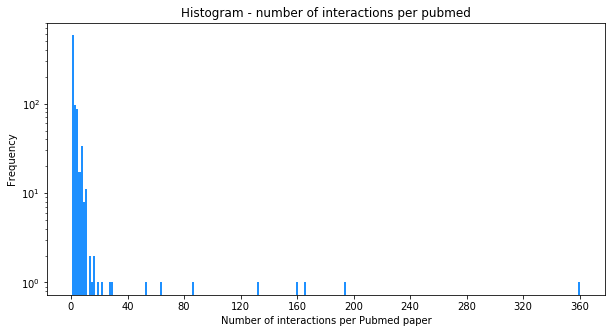

In [12]:
import matplotlib.pyplot as plt
import numpy as np 

ax = plt.axes( yscale='log')
ax.xaxis.set_major_locator(plt.MaxNLocator(10, prune='lower'))

#sns.distplot(data.pubmedId.value_counts().tolist(), bins=100, kde=False, norm_hist=True)

data.pubmedId.value_counts().plot.hist (bins=250,figsize=(10,5), ax=ax, color='dodgerblue')
plt.title('Histogram - number of interactions per pubmed')
plt.xlabel('Number of interactions per Pubmed paper')
plt.ylabel('Frequency')
#plt.show()
plt.savefig('PaperVsInteractions.svg', bbox_inches='tight')
plt.savefig('PaperVsInteractions.jpg', bbox_inches='tight')
plt.show()

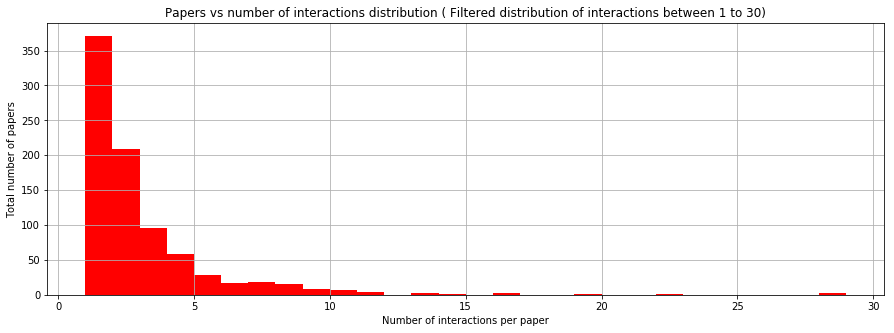

In [13]:
df = data.pubmedId.value_counts().hist (bins=range(1, 30), figsize=(15,5), color = 'red')

plt.title('Papers vs number of interactions distribution ( Filtered distribution of interactions between 1 to 30)')
plt.xlabel('Number of interactions per paper')
plt.ylabel('Total number of papers')

plt.show()

### Interaction Types distribution

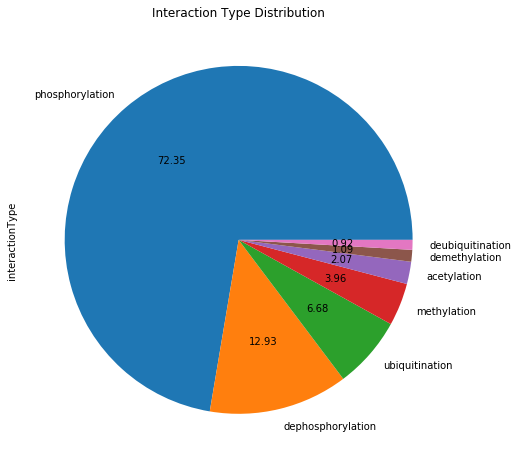

In [14]:
data.interactionType.value_counts().plot.pie(autopct='%.2f',figsize=(8, 8))
plt.title('Interaction Type Distribution')
plt.savefig("Interactiontype.svg")
plt.show()

In [15]:
data.interactionType.value_counts().to_frame()

,interactionType
phosphorylation,2446
dephosphorylation,437
ubiquitination,226
methylation,134
acetylation,70
demethylation,37
deubiquitination,31


### Distinct interaction types per paper

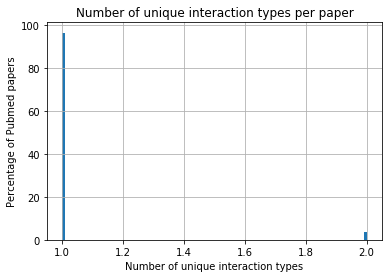

In [16]:
import numpy as np

distinct_no_papers = data['pubmedId'].nunique()

data.groupby('pubmedId')['interactionType'].nunique().hist(bins=100, density=1)
plt.title("Number of unique interaction types per paper")
plt.xlabel('Number of unique interaction types')
plt.ylabel('Percentage of Pubmed papers'.format(distinct_no_papers))
plt.show()


### Postive vs Negative Relationships

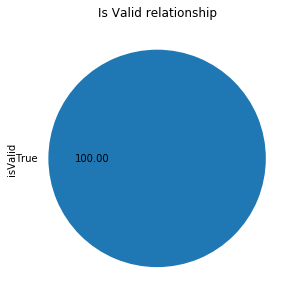

In [17]:
data.isValid.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Is Valid relationship')
plt.show()

### Number of participants per interaction

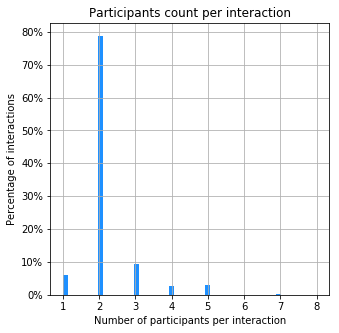

In [18]:
import numpy as np
import matplotlib.ticker as mtick


fig, ax = plt.subplots( 1,1, figsize=(15,5))



#fig, ax = plt.subplots( 7,1, figsize=(45,30))
c_ax= ax
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())

data['participants_count'] = data["participants"].apply(lambda x: len(x))

data['participants_count'].hist (bins=50, ax=c_ax, figsize=(5,5), color = 'dodgerblue',  weights = np.ones_like(data['participants_count'].index)*100 / len(data['participants_count'].index))
plt.title("Participants count per interaction")
plt.xlabel('Number of participants per interaction')
plt.ylabel('Percentage of interactions')
plt.savefig("ParticipantsPerInteraction.svg")
plt.show()

### Explore if the abstract contains the trigger word

In [19]:
data["hasTriggerWord"] = data.apply(lambda r: r["interactionType"].lower() in r["pubmedabstract"].lower() , 1)

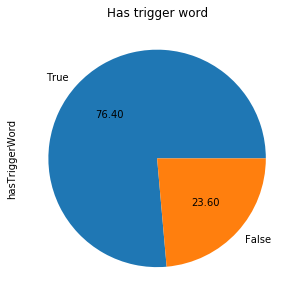

In [20]:
data.hasTriggerWord.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Has trigger word')
plt.show()

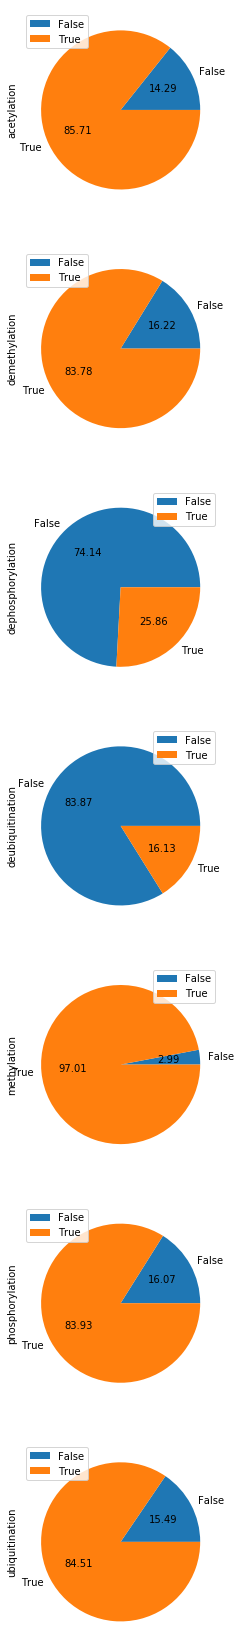

In [21]:
fig, ax = plt.subplots( 7,1, figsize=(45,30))
data.groupby(['hasTriggerWord', 'interactionType']).size().unstack().plot(kind='pie', subplots='True',autopct='%.2f', ax=ax)
plt.show()

### Explore how many of the entity alias are mentioned in the abstract

In [22]:
%%time 

from difflib import SequenceMatcher
def getEntityMentionsCount(r):
    count = 0
    abstract = r["pubmedabstract"].lower()
    abstract_len= len(abstract)
    for p in r["participants"]:
        if p is None or p['alias'] is None : continue
        
        for a in p['alias']:
            alias = a[0].lower()
            s = SequenceMatcher(None, abstract, alias)
            _,_,match_size = s.find_longest_match(0, len(abstract), 0, len(alias))
            if match_size >= 3 and match_size >= len(alias)/2 :
                count += 1
        
    return count
        

data["entityMentionsCount"] = data.apply(lambda r: getEntityMentionsCount(r)  , 1)

CPU times: user 28.3 s, sys: 363 ms, total: 28.7 s
Wall time: 30.8 s


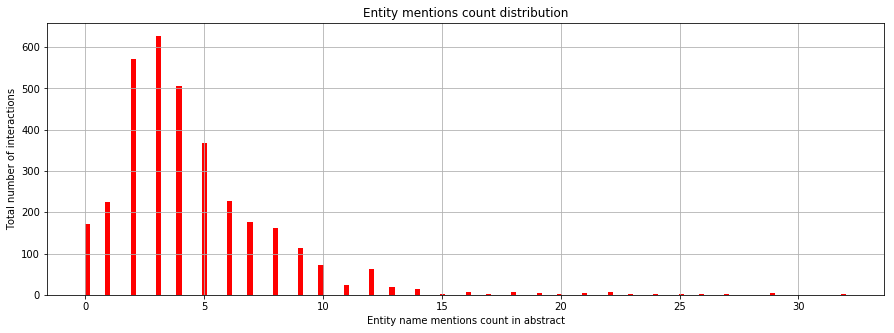

In [23]:
data['entityMentionsCount'].hist ( bins=150, figsize=(15,5), color = 'red')
plt.title('Entity mentions count distribution')
plt.xlabel('Entity name mentions count in abstract')
plt.ylabel('Total number of interactions')

plt.show()

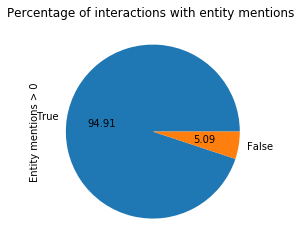

In [24]:
(data['entityMentionsCount'] > 0).value_counts().plot.pie(autopct='%.2f')
plt.title("Percentage of interactions with entity mentions ")
plt.ylabel("Entity mentions > 0")
plt.show()

### Randomly eye ball interactions with no entity mentions

In [25]:

data.query('entityMentionsCount == 0')[['participants','pubmedabstract' ]].sample(n=3)


,participants,pubmedabstract
963,"[{'uniprotid': 'P49674', 'alias': [['kc1e_human'], ['Casein kinase I isoform epsilon'], ['CSNK1E']]}, {'uniprotid': 'Q15162', 'alias': [['apc_human'], ['Adenomatous polyposis coli protein'], ['APC'], ['DP2.5'], ['Deleted in polyposis 2.5']]}]","Although casein kinase Iepsilon (CKIepsilon) has been shown to regulate the Wnt signaling pathway positively, its mode of action is not clear. In this study we show that CKIepsilon activates the Wnt signaling pathway in co-operation with Dvl. CKIepsilon and Axin associated with different sites of Dvl, and CKIepsilon and Dvl interacted with distinct regions on Axin. Therefore, these three proteins formed a ternary complex. Either low expression of Dvl or CKIepsilon alone did not accumulate beta-catenin, but their co-expression accumulated greatly. Dvl and CKIepsilon activated the transcriptional activity of T cell factor (Tcf) synergistically. Although the Dvl mutant that binds to Axin but not to CKIepsilon activated Tcf, it did not synergize with CKIepsilon. Another Dvl mutant that does not bind to Axin did not activate Tcf irrespective of the presence of CKIepsilon. Furthermore, Dvl and CKIepsilon co-operatively induced axis duplication of Xenopus embryos. These results indicate that Dvl and CKIepsilon synergistically activated the Wnt signaling pathway and that the binding of the complex of Dvl and CKIepsilon to Axin is necessary for their synergistic action."
1262,"[{'uniprotid': 'Q92534', 'alias': [['hdac1_human'], ['Histone deacetylase 1'], ['HDAC1'], ['RPD3L1']]}, {'uniprotid': 'Q5U065', 'alias': [['csk21_human'], ['Casein kinase II subunit alpha'], ['CSNK2A1'], ['CK2A1']]}]","Deciphering the kinase-substrate relationship is vital for the study of phosphorylation network. The use of immobilized proteins on protein chip as the library for screening of potential kinase substrates is a tried-and-tested method. However, information on phosphorylation sites is lacking and the creation of the library with proteins of whole proteome by recombinant expression is costly and difficult. In this study, a new solid-phase approach by immobilization of proteins from cell lysate onto beads as a protein library for kinase substrate screening was developed. It was found that consensus phosphorylation sites motif for kinase substrates could be accurately determined and hundreds of in vitro kinase substrates and their phosphorylation sites could be identified by using this method."
1376,"[{'uniprotid': 'Q5U065', 'alias': [['csk21_human'], ['Casein kinase II subunit alpha'], ['CSNK2A1'], ['CK2A1']]}, {'uniprotid': 'Q8IYB3-1', 'alias': [['q8iyb3-1'], ['Serine/arginine repetitive matrix protein 1'], ['SRRM1'], ['SRM160'], ['SR-related nuclear matrix protein of 160 kDa'], ['Ser/Arg-related nuclear matrix protein']]}]","Deciphering the kinase-substrate relationship is vital for the study of phosphorylation network. The use of immobilized proteins on protein chip as the library for screening of potential kinase substrates is a tried-and-tested method. However, information on phosphorylation sites is lacking and the creation of the library with proteins of whole proteome by recombinant expression is costly and difficult. In this study, a new solid-phase approach by immobilization of proteins from cell lysate onto beads as a protein library for kinase substrate screening was developed. It was found that consensus phosphorylation sites motif for kinase substrates could be accurately determined and hundreds of in vitro kinase substrates and their phosphorylation sites could be identified by using this method."


In [26]:
data.head(n=10)

,interactionId,interactionType,participants,pubmedId,pubmedTitle,pubmedabstract,isValid,participants_count,hasTriggerWord,entityMentionsCount
0,2503510,phosphorylation,"[{'uniprotid': 'P43405', 'alias': [['ksyk_human'], ['Tyrosine-protein kinase SYK'], ['SYK'], ['Spleen tyrosine kinase'], ['p72-Syk']]}]",25605870,None,"NLRP3 is the most crucial member of the NLR family, as it detects the existence of pathogen invasion and self-derived molecules associated with cellular damage. Several studies have reported that excessive NLRP3 inflammasome-mediated caspase-1 activation is a key factor in the development of diseases. Recent studies have reported that Syk is involved in pathogen-induced NLRP3 inflammasome activation; however, the detailed mechanism linking Syk to NLRP3 inflammasome remains unclear. In this study, we showed that Syk mediates NLRP3 stimuli-induced processing of procaspase-1 and the consequent activation of caspase-1. Moreover, the kinase activity of Syk is required to potentiate caspase-1 activation in a reconstituted NLRP3 inflammasome system in HEK293T cells. The adaptor protein ASC bridges NLRP3 with the effector protein caspase-1. Herein, we find that Syk can associate directly with ASC and NLRP3 by its kinase domain but interact indirectly with procaspase-1. Syk can phosphorylate ASC at Y146 and Y187 residues, and the phosphorylation of both residues is critical to enhance ASC oligomerization and the recruitment of procaspase-1. Together, our results reveal a new molecular pathway through which Syk promotes NLRP3 inflammasome formation, resulting from the phosphorylation of ASC. Thus, the control of Syk activity might be effective to modulate NLRP3 inflammasome activation and treat NLRP3-related immune diseases.",True,1,True,1
1,2503513,phosphorylation,"[{'uniprotid': 'P43405', 'alias': [['ksyk_human'], ['Tyrosine-protein kinase SYK'], ['SYK'], ['Spleen tyrosine kinase'], ['p72-Syk']]}, {'uniprotid': 'Q9BSZ5', 'alias': [['asc_human'], ['Apoptosis-associated speck-like protein containing a CARD'], ['PYD and CARD domain-containing protein'], ['Target of methylation-induced silencing 1'], ['Caspase recruitment domain-containing protein 5'], ['ASC'], ['CARD5'], ['TMS1'], ['PYCARD']]}]",25605870,None,"NLRP3 is the most crucial member of the NLR family, as it detects the existence of pathogen invasion and self-derived molecules associated with cellular damage. Several studies have reported that excessive NLRP3 inflammasome-mediated caspase-1 activation is a key factor in the development of diseases. Recent studies have reported that Syk is involved in pathogen-induced NLRP3 inflammasome activation; however, the detailed mechanism linking Syk to NLRP3 inflammasome remains unclear. In this study, we showed that Syk mediates NLRP3 stimuli-induced processing of procaspase-1 and the consequent activation of caspase-1. Moreover, the kinase activity of Syk is required to potentiate caspase-1 activation in a reconstituted NLRP3 inflammasome system in HEK293T cells. The adaptor protein ASC bridges NLRP3 with the effector protein caspase-1. Herein, we find that Syk can associate directly with ASC and NLRP3 by its kinase domain but interact indirectly with procaspase-1. Syk can phosphorylate ASC at Y146 and Y187 residues, and the phosphorylation of both residues is critical to enhance ASC oligomerization and the recruitment of procaspase-1. Together, our results reveal a new molecular pathway through which Syk promotes NLRP3 inflammasome formation, resulting from the phosphorylation of ASC. Thus, the control of Syk activity might be effective to modulate NLRP3 inflammasome activation and treat NLRP3-related immune diseases.",True,2,True,2
10,1796163,phosphorylation,"[{'uniprotid': 'Q8WUB1', 'alias': [['kc1g2_human'], ['Casein kinase I isoform gamma-2'], ['CK1G2'], ['CSNK1G2']]}, {'uniprotid': 'Q6ZS50', 'alias': [['lrrk2_human'], ['Leucine-rich repeat serine/threonine-protein kinase 2'], ['LRRK2'], ['PARK8'], ['Dardarin']]}]",

## Data Transformation

### Filter interactions with more than 2 participants

In [27]:
filtered = data.query('participants_count <= 2')
filtered.shape

(2868, 10)

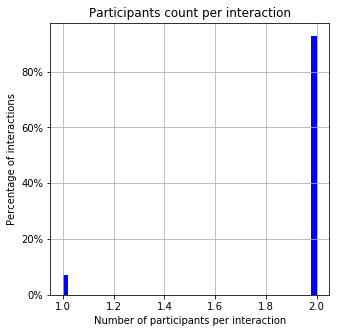

In [28]:
import matplotlib.ticker as mtick


fig, ax = plt.subplots( 1,1, figsize=(15,5))



c_ax= ax
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
filtered['participants_count'].hist (bins=50, figsize=(5,5), ax=c_ax, color = 'blue',  weights = np.ones_like(filtered['participants_count'].index)*100 / len(filtered['participants_count'].index))
plt.title("Participants count per interaction")
plt.xlabel('Number of participants per interaction')
plt.ylabel('Percentage of interactions')
plt.savefig("ParticipantsPerInteraction.svg")
plt.show()

### Filter out interactions from paper with more than 15 interactions

/Users/aeg/miniconda/envs/untitled2/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


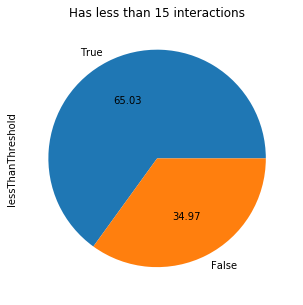

In [29]:
pubmed_interaction_count = filtered.pubmedId.value_counts().to_frame().rename(columns={"pubmedId":"interactionCountPerPubmed"})


#interactions_count= pd.DataFrame()
filtered["lessThanThreshold"] = filtered.apply(lambda r: r["pubmedId"] in  pubmed_interaction_count.query('interactionCountPerPubmed <= 15').index , 1)


filtered.lessThanThreshold.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Has less than 15 interactions')
plt.show()

In [30]:
filtered = filtered.query("lessThanThreshold == 1")

In [31]:
print("Total number of records after filter: {}".format(filtered.shape[0]))

Total number of records after filter: 1865


###  Flatten partcipants into participant 1 and particpiant 2

In [32]:
from datatransformer.jsonPPIFlattenTransformer import IntactJsonPpiFlattenTransformer
 

sut = IntactJsonPpiFlattenTransformer()

data_transformed = sut.transform(filtered)


In [33]:
data_transformed.head(n=2)

,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isValid,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,participants_count,pubmedId,pubmedTitle,pubmedabstract
0,1,True,2503510,phosphorylation,True,True,"[[ksyk_human], [Tyrosine-protein kinase SYK], [SYK], [Spleen tyrosine kinase], [p72-Syk]]",P43405,"[[ksyk_human], [Tyrosine-protein kinase SYK], [SYK], [Spleen tyrosine kinase], [p72-Syk]]",P43405,1,25605870,None,"NLRP3 is the most crucial member of the NLR family, as it detects the existence of pathogen invasion and self-derived molecules associated with cellular damage. Several studies have reported that excessive NLRP3 inflammasome-mediated caspase-1 activation is a key factor in the development of diseases. Recent studies have reported that Syk is involved in pathogen-induced NLRP3 inflammasome activation; however, the detailed mechanism linking Syk to NLRP3 inflammasome remains unclear. In this study, we showed that Syk mediates NLRP3 stimuli-induced processing of procaspase-1 and the consequent activation of caspase-1. Moreover, the kinase activity of Syk is required to potentiate caspase-1 activation in a reconstituted NLRP3 inflammasome system in HEK293T cells. The adaptor protein ASC bridges NLRP3 with the effector protein caspase-1. Herein, we find that Syk can associate directly with ASC and NLRP3 by its kinase domain but interact indirectly with procaspase-1. Syk can phosphorylate ASC at Y146 and Y187 residues, and the phosphorylation of both residues is critical to enhance ASC oligomerization and the recruitment of procaspase-1. Together, our results reveal a new molecular pathway through which Syk promotes NLRP3 inflammasome formation, resulting from the phosphorylation of ASC. Thus, the control of Syk activity might be effective to modulate NLRP3 inflammasome activation and treat NLRP3-related immune diseases."
1,2,True,2503513,phosphorylation,True,True,"[[ksyk_human], [Tyrosine-protein kinase SYK], [SYK], [Spleen tyrosine kinase], [p72-Syk]]",P43405,"[[asc_human], [Apoptosis-associated speck-like protein containing a CARD], [PYD and CARD domain-containing protein], [Target of methylation-induced silencing 1], [Caspase recruitment domain-containing protein 5], [ASC], [CARD5], [TMS1], [PYCARD]]",Q9BSZ5,2,25605870,None,"NLRP3 is the most crucial member of the NLR family, as it detects the existence of pathogen invasion and self-derived molecules associated with cellular damage. Several studies have reported that excessive NLRP3 inflammasome-mediated caspase-1 activation is a key factor in the development of diseases. Recent studies have reported that Syk is involved in pathogen-induced NLRP3 inflammasome activation; however, the detailed mechanism linking Syk to NLRP3 inflammasome remains unclear. In this study, we showed that Syk mediates NLRP3 stimuli-induced processing of procaspase-1 and the consequent activation of caspase-1. Moreover, the kinase activity of Syk is required to potentiate caspase-1 activation in a reconstituted NLRP3 inflammasome system in HEK293T cells. The adaptor protein ASC bridges NLRP3 with the effector protein caspase-1. Herein, we find that Syk can associate directly with ASC and NLRP3 by its kinase domain but interact indirectly with procaspase-1. Syk can phosphorylate ASC at Y146 and Y187 residues, and the phosphorylation of both residues is critical to enhance ASC oligomerization and the recruitment of procaspase-1. Together, our results reveal a new molecular pathway through which Syk promotes NLRP3 inflammasome formation, resulting from the phosphorylation of ASC. Thus, the control of Syk activity might be effective to modulate NLRP3 inflammasome activation and treat NLRP3-related immune diseases."


In [34]:
data_transformed.shape

(1865, 14)

### Remove records where the alias is null

In [35]:
data_transformed.shape

(1865, 14)

In [36]:
data_filtered = data_transformed[data_transformed.participant1Id.notnull()]
data_filtered.shape

(1795, 14)

In [37]:
data_filtered = data_filtered[data_filtered.participant2Id.notnull()]
data_filtered.shape

(1766, 14)

In [38]:
data_filtered.head(n=2)

,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isValid,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,participants_count,pubmedId,pubmedTitle,pubmedabstract
0,1,True,2503510,phosphorylation,True,True,"[[ksyk_human], [Tyrosine-protein kinase SYK], [SYK], [Spleen tyrosine kinase], [p72-Syk]]",P43405,"[[ksyk_human], [Tyrosine-protein kinase SYK], [SYK], [Spleen tyrosine kinase], [p72-Syk]]",P43405,1,25605870,None,"NLRP3 is the most crucial member of the NLR family, as it detects the existence of pathogen invasion and self-derived molecules associated with cellular damage. Several studies have reported that excessive NLRP3 inflammasome-mediated caspase-1 activation is a key factor in the development of diseases. Recent studies have reported that Syk is involved in pathogen-induced NLRP3 inflammasome activation; however, the detailed mechanism linking Syk to NLRP3 inflammasome remains unclear. In this study, we showed that Syk mediates NLRP3 stimuli-induced processing of procaspase-1 and the consequent activation of caspase-1. Moreover, the kinase activity of Syk is required to potentiate caspase-1 activation in a reconstituted NLRP3 inflammasome system in HEK293T cells. The adaptor protein ASC bridges NLRP3 with the effector protein caspase-1. Herein, we find that Syk can associate directly with ASC and NLRP3 by its kinase domain but interact indirectly with procaspase-1. Syk can phosphorylate ASC at Y146 and Y187 residues, and the phosphorylation of both residues is critical to enhance ASC oligomerization and the recruitment of procaspase-1. Together, our results reveal a new molecular pathway through which Syk promotes NLRP3 inflammasome formation, resulting from the phosphorylation of ASC. Thus, the control of Syk activity might be effective to modulate NLRP3 inflammasome activation and treat NLRP3-related immune diseases."
1,2,True,2503513,phosphorylation,True,True,"[[ksyk_human], [Tyrosine-protein kinase SYK], [SYK], [Spleen tyrosine kinase], [p72-Syk]]",P43405,"[[asc_human], [Apoptosis-associated speck-like protein containing a CARD], [PYD and CARD domain-containing protein], [Target of methylation-induced silencing 1], [Caspase recruitment domain-containing protein 5], [ASC], [CARD5], [TMS1], [PYCARD]]",Q9BSZ5,2,25605870,None,"NLRP3 is the most crucial member of the NLR family, as it detects the existence of pathogen invasion and self-derived molecules associated with cellular damage. Several studies have reported that excessive NLRP3 inflammasome-mediated caspase-1 activation is a key factor in the development of diseases. Recent studies have reported that Syk is involved in pathogen-induced NLRP3 inflammasome activation; however, the detailed mechanism linking Syk to NLRP3 inflammasome remains unclear. In this study, we showed that Syk mediates NLRP3 stimuli-induced processing of procaspase-1 and the consequent activation of caspase-1. Moreover, the kinase activity of Syk is required to potentiate caspase-1 activation in a reconstituted NLRP3 inflammasome system in HEK293T cells. The adaptor protein ASC bridges NLRP3 with the effector protein caspase-1. Herein, we find that Syk can associate directly with ASC and NLRP3 by its kinase domain but interact indirectly with procaspase-1. Syk can phosphorylate ASC at Y146 and Y187 residues, and the phosphorylation of both residues is critical to enhance ASC oligomerization and the recruitment of procaspase-1. Together, our results reveal a new molecular pathway through which Syk promotes NLRP3 inflammasome formation, resulting from the phosphorylation of ASC. Thus, the control of Syk activity might be effective to modulate NLRP3 inflammasome activation and treat NLRP3-related immune diseases."


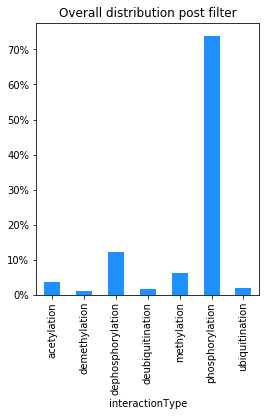

In [39]:
fig, ax = plt.subplots( 1,1, figsize=(4,5))



#fig, ax = plt.subplots( 7,1, figsize=(45,30))
c_ax= ax
c_ax.set_title('Overall distribution post filter')
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 10)))

data_filtered.groupby(['interactionType']).size().apply(lambda x: 100 * x / float(len(data_filtered.interactionType))).plot.bar(ax=c_ax, color='dodgerblue')


plt.savefig("Interactiontype_postfilter.svg", bbox_inches='tight')
plt.savefig("Interactiontype_postfilter.png", bbox_inches='tight')


plt.show()

Okay.. looks like it is only a case of the names of the participants not matching the names of the alias used in the abstract.. 

### Data Engineering

### Normalise abstract

In [40]:

def normalise_absract(data, enity_annotations_file):
    from datatransformer.abstractGeneNormaliser import AbstractGeneNormaliser
    from datatransformer.ncbiGeneUniprotLocalDbMapper import NcbiGeneUniprotLocalDbMapper

    from dataformatters.gnormplusPubtatorReader import GnormplusPubtatorReader


    import os
    
 
    localdb = human_idmapping_dat
    with open(localdb, "r") as dbhandle:
        mapper = NcbiGeneUniprotLocalDbMapper(dbhandle, "GeneID") 
            
        #Read gnormplus identified entities
        reader = GnormplusPubtatorReader()
        with open(enity_annotations_file,"r") as handle:
            annotations_json = list(reader(handle))

        normaliser = AbstractGeneNormaliser(annotations_json, mapper)
        result = normaliser.transform(data)
        
       

        return result

In [41]:
data_filtered = normalise_absract(data_filtered, annotations_file)

In [42]:
data_filtered.shape

(1766, 15)

### Split Train/Test/validation

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

unique_pubmed = data_filtered.pubmedId.unique()
stratified =  [ data_filtered.query("pubmedId == '{}'".format(p))['interactionType'].iloc[0] for p in unique_pubmed]
trainpubmed, valpubmed  = train_test_split(unique_pubmed,  test_size=.1,
                                                        random_state=777, stratify=stratified)


stratified =  [data_filtered.query("pubmedId == '{}'".format(p))['interactionType'].iloc[0] for p in trainpubmed]
trainpubmed, testpubmed = train_test_split(trainpubmed,  test_size=.2,
                                                        random_state=777, stratify=stratified)

In [44]:
train = data_filtered[data_filtered['pubmedId'].isin(trainpubmed)]
test = data_filtered[data_filtered['pubmedId'].isin(testpubmed)]
val = data_filtered[data_filtered['pubmedId'].isin(valpubmed)]




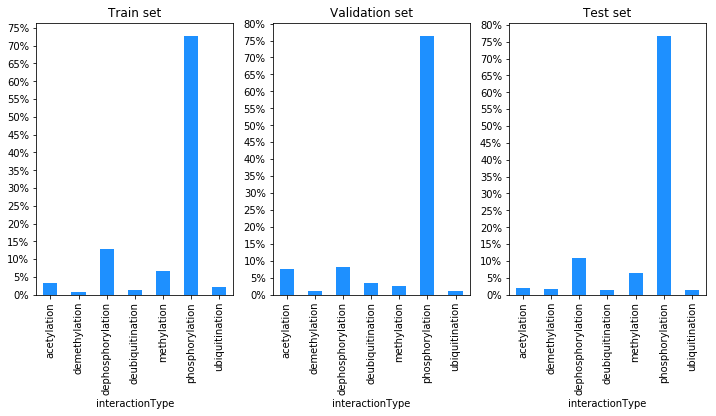

In [45]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as mtick


fig, ax = plt.subplots( 1,3, figsize=(12,5))



#fig, ax = plt.subplots( 7,1, figsize=(45,30))
c_ax= ax[0]
c_ax.set_title('Train set')
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 5)))
train.groupby(['interactionType']).size().apply(lambda x: 100 * x / float(len(train.interactionType))).plot.bar(ax=c_ax, color='dodgerblue')




c_ax = ax[1] 
c_ax.set_title('Validation set')
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 5)))
val.groupby(['interactionType']).size().apply(lambda x: 100 * x / float(len(val.interactionType))).plot.bar(ax=c_ax, color='dodgerblue')



c_ax = ax[2] 
c_ax.set_title('Test set')
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 5)))
test.groupby(['interactionType']).size().apply(lambda x: 100 * x / float(len(test.interactionType))).plot.bar(ax=c_ax, color='dodgerblue')




plt.savefig("split_dataset_postfilter.svg", bbox_inches='tight')
plt.savefig("split_dataset_postfilter.png", bbox_inches='tight')

plt.show()

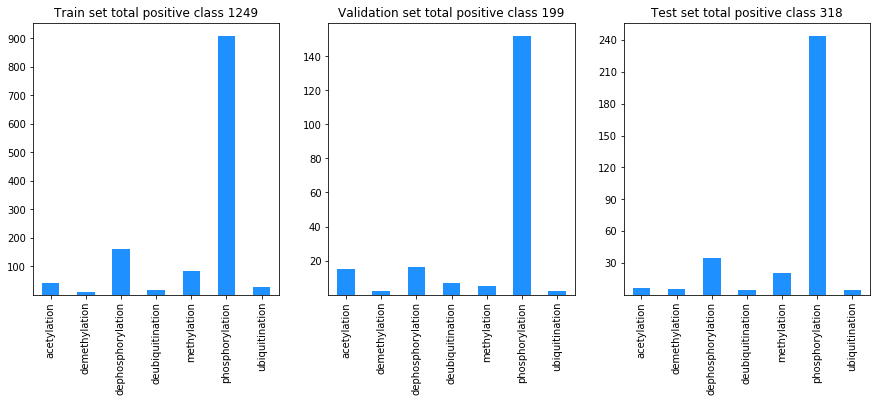

In [46]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as mtick


fig, ax = plt.subplots( 1,3, figsize=(15,5))



#fig, ax = plt.subplots( 7,1, figsize=(45,30))
c_ax= ax[0]
c_ax.set_title('Train set total positive class {}'.format(train.shape[0]))
c_ax.yaxis.set_major_locator(plt.MaxNLocator( prune='both'))
train.interactionType.value_counts().sort_index().plot.bar(ax=c_ax, color='dodgerblue')




c_ax = ax[1] 
c_ax.set_title('Validation set total positive class {}'.format(val.shape[0]))
c_ax.yaxis.set_major_locator(plt.MaxNLocator( prune='both'))
val.interactionType.value_counts().sort_index().plot.bar(ax=c_ax, color='dodgerblue')

c_ax = ax[2] 
c_ax.set_title('Test set total positive class {}'.format(test.shape[0]))
c_ax.yaxis.set_major_locator(plt.MaxNLocator( prune='both'))
test.interactionType.value_counts().sort_index().plot.bar(ax=c_ax,  color='dodgerblue')


plt.savefig('TrainTestValidationInteractionDistribution.svg', bbox_inches='tight')
plt.savefig('TrainTestValidationInteractionDistribution.jpeg', bbox_inches='tight')


plt.show()

### Generate negative samples

In [47]:

# def generate_negative_old(data):
#     import uuid
#     unique_pubmeds = data["pubmedId"].unique()
#     data_fake = pd.DataFrame(columns=data.columns)

#     num_fake_records = int( .50 * len(data))
#     #TODO: Randomise this, biased via
#     for u in unique_pubmeds:
#         fake_records = pd.DataFrame(data[ data.pubmedId != u]  ).sample(n=1) 
#         fake_records.loc[:, "interactionId"] =  fake_records.interactionId.astype(str) + "_" + str(uuid.uuid4() ) + "_" + "fake"
#         fake_records.loc[:,"isValid"] = 'False' 
#         ## Copy of the pubmeid abtract and the title from a id
#         fake_records.loc[:,"pubmedId"] = u
#         fake_records.loc[:, "pubmedTitle"] =  data[ data.pubmedId == u].iloc[0]["pubmedTitle"]
#         fake_records.loc[:, "pubmedabstract"] =  data[ data.pubmedId == u].iloc[0]["pubmedabstract"]


#         data_fake = data_fake.append(fake_records, ignore_index=True)
#         if len(data_fake) > num_fake_records:
#             break
            
#     return data_fake
  
    

In [48]:

def generate_negative_entity(data, enity_annotations_file):
    from dataformatters.gnormplusPubtatorReader import GnormplusPubtatorReader
    from datatransformer.gnormplusNegativeSamplesAugmentor import GnormplusNegativeSamplesAugmentor
    from datatransformer.ncbiGeneUniprotLocalDbMapper import NcbiGeneUniprotLocalDbMapper

    import os
    
 
    localdb = human_idmapping_dat
    with open(localdb, "r") as dbhandle:
        mapper = NcbiGeneUniprotLocalDbMapper(dbhandle, "GeneID") 
            
        #Read gnormplus identified entities
        reader = GnormplusPubtatorReader()
        with open(enity_annotations_file,"r") as handle:
            annotations_json = list(reader(handle))

        negative_samples_generator = GnormplusNegativeSamplesAugmentor(annotations_json, mapper)
        result = negative_samples_generator.transform(data)
        
        

        return result

In [49]:

def generate_negative_interaction(data):

    from datatransformer.interactionTypeNegativeSamplesAugmentor import InteractionTypeNegativeSamplesAugmentor

    import os
    
    negative_samples_generator = InteractionTypeNegativeSamplesAugmentor()
    result = negative_samples_generator.transform(data)


    return result

In [50]:
def plot_negative_distribution(train,val, test, heading, fig, ax  ):
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mtick
    
    fig.suptitle(heading)
    #fig, ax = plt.subplots( 7,1, figsize=(45,30))
    c_ax= ax[0]
    c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    c_ax.set_title( "Training PPI {}".format( train.shape[0]))
    c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 10)))
    train.groupby(['interactionType', 'isValid']).size().groupby( level=0).apply(lambda x:
                                                     100 * x / float(x.sum())).unstack().plot.bar(ax=c_ax)



    c_ax= ax[1]
    c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    c_ax.set_title( "Validation PPI {}".format(val.shape[0]))
    c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 10)))
    val.groupby(['interactionType', 'isValid']).size().groupby( level=0).apply(lambda x:
                                                     100 * x / float(x.sum())).unstack().plot.bar(ax=c_ax)



    c_ax= ax[2]
    c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    c_ax.set_title( "Test PPI {}".format(test.shape[0]))
    c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 10)))
    test.groupby(['interactionType', 'isValid']).size().groupby( level=0).apply(lambda x:
                                                     100 * x / float(x.sum())).unstack().plot.bar(ax=c_ax)



   

#### Step1: Add negative entity pairs

In [51]:

train = generate_negative_entity(train, annotations_file)
test = generate_negative_entity(test,  annotations_file)
val = generate_negative_entity(val, annotations_file)



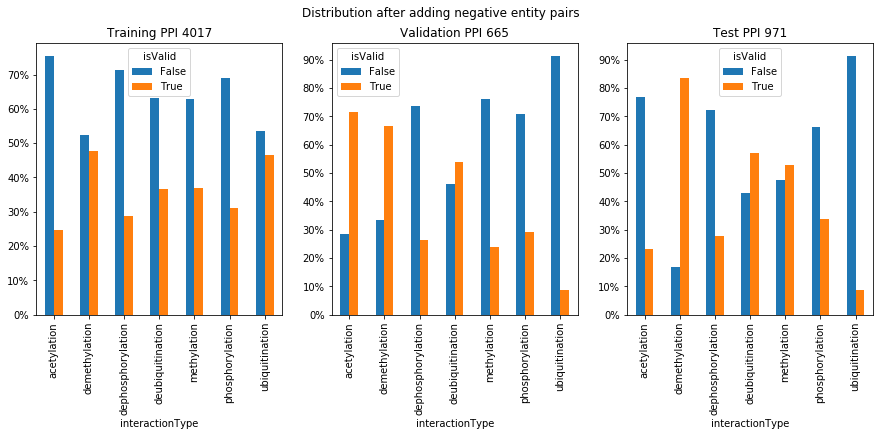

In [52]:
fig, ax = plt.subplots( 1,3, figsize=(15,5))


plot_negative_distribution(train,  val, test, "Distribution after adding negative entity pairs",fig, ax)
plt.savefig("EntityNegativeSample.jpeg",bbox_inches = "tight")
plt.savefig("EntityNegativeSample.svg",bbox_inches = "tight")
plt.show()

#### Step 2: Add negative interaction types

In [53]:

train = generate_negative_interaction(train)
test = generate_negative_interaction(test)
val = generate_negative_interaction(val)


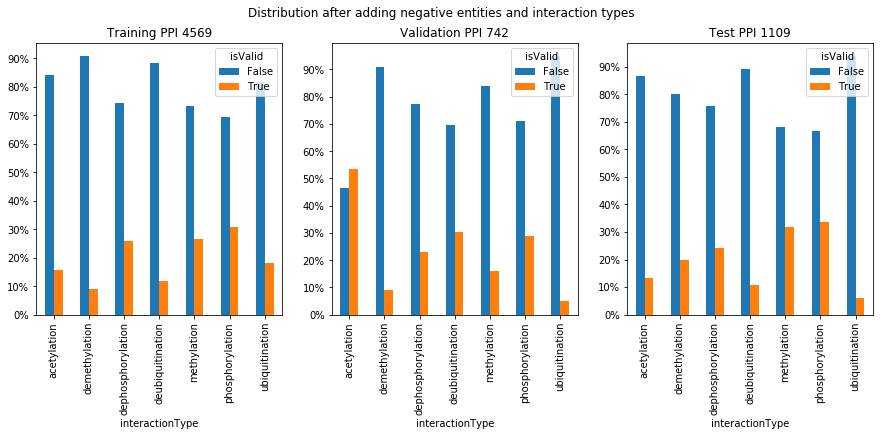

In [54]:

fig, ax = plt.subplots( 1,3, figsize=(15,5))

plot_negative_distribution(train,  val, test, "Distribution after adding negative entities and interaction types",fig, ax)
plt.savefig("EntityInteractionNegativeSample.jpeg",bbox_inches = "tight")
plt.savefig("EntityInteractionNegativeSample.svg",bbox_inches = "tight")
plt.show()

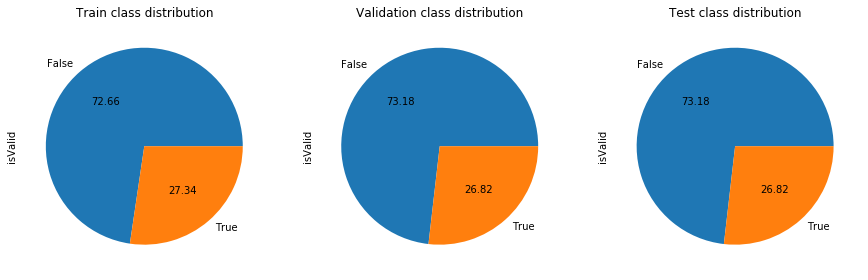

In [55]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize=(15,20))

ax[0].set_title('Train class distribution')
train.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[0])

ax[1].set_title('Validation class distribution')
val.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[1])


ax[2].set_title('Test class distribution')
val.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[2])



plt.savefig("Interaction.png")

In [56]:
train.to_json("train_unique_pub_v4_less_negative.json")
test.to_json("test_unique_pub_v4_less_negative.json")
val.to_json("val_unique_pub_v4_less_negative.json")

In [57]:
train.head(n=3)

,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isValid,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,participants_count,pubmedId,pubmedTitle,pubmedabstract,normalised_abstract
0,2,True,2503513_a2c1715f-17ad-4891-b6e6-86069953bbf6_fake_interaction,deubiquitination,False,True,"[[ksyk_human], [Tyrosine-protein kinase SYK], [SYK], [Spleen tyrosine kinase], [p72-Syk]]",P43405,"[[asc_human], [Apoptosis-associated speck-like protein containing a CARD], [PYD and CARD domain-containing protein], [Target of methylation-induced silencing 1], [Caspase recruitment domain-containing protein 5], [ASC], [CARD5], [TMS1], [PYCARD]]",Q9BSZ5,2,25605870,None,"NLRP3 is the most crucial member of the NLR family, as it detects the existence of pathogen invasion and self-derived molecules associated with cellular damage. Several studies have reported that excessive NLRP3 inflammasome-mediated caspase-1 activation is a key factor in the development of diseases. Recent studies have reported that Syk is involved in pathogen-induced NLRP3 inflammasome activation; however, the detailed mechanism linking Syk to NLRP3 inflammasome remains unclear. In this study, we showed that Syk mediates NLRP3 stimuli-induced processing of procaspase-1 and the consequent activation of caspase-1. Moreover, the kinase activity of Syk is required to potentiate caspase-1 activation in a reconstituted NLRP3 inflammasome system in HEK293T cells. The adaptor protein ASC bridges NLRP3 with the effector protein caspase-1. Herein, we find that Syk can associate directly with ASC and NLRP3 by its kinase domain but interact indirectly with procaspase-1. Syk can phosphorylate ASC at Y146 and Y187 residues, and the phosphorylation of both residues is critical to enhance ASC oligomerization and the recruitment of procaspase-1. Together, our results reveal a new molecular pathway through which Syk promotes NLRP3 inflammasome formation, resulting from the phosphorylation of ASC. Thus, the control of Syk activity might be effective to modulate NLRP3 inflammasome activation and treat NLRP3-related immune diseases.","Q96P20 is the most crucial member of the NLR family, as it detects the existence of pathogen invasion and self-derived molecules associated with cellular damage. Several studies have reported that excessive Q96P20 inflammasome-mediated A8K249 activation is a key factor in the development of diseases. Recent studies have reported that A0A024R273 is involved in pathogen-induced Q96P20 inflammasome activation; however, the detailed mechanism linking A0A024R273 to Q96P20 inflammasome remains unclear. In this study, we showed that A0A024R273 mediates Q96P20 stimuli-induced processing of procaspase-1 and the consequent activation of A8K249. Moreover, the kinase activity of A0A024R273 is required to potentiate A8K249 activation in a reconstituted Q96P20 inflammasome system in HEK293T cells. The adaptor protein Q9ULZ3 bridges Q96P20 with the effector protein A8K249. Herein, we find that A0A024R273 can associate directly with Q9ULZ3 and Q96P20 by its kinase domain but interact indirectly with procaspase-1. A0A024R273 can phosphorylate Q9ULZ3 at Y146 and Y187 residues, and the phosphorylation of both residues is critical to enhance Q9ULZ3 oligomerization and the recruitment of procaspase-1. Together, our results reveal a new molecular pathway through which A0A024R273 promotes Q96P20 inflammasome formation, resulting from the phosphorylation of Q9ULZ3. Thus, the control of A0A024R273 activity might be effective to modulate Q96P20 inflammasome activation and treat Q96P20-related immune diseases."
1,4,True,1160335_d8c8de66-a9a9-4869-90db-4c4e10cc57a8_fake_interaction,ubiquitination,False,True,"[[akt1_human], [RAC-alpha serine/threonine-protein kinase], [AKT1], [PKB], [RAC], [RAC-PK-alpha], [Protein kinase B], [Proto-oncogene c-Akt], [Protein kinase B alpha]]",B7Z5R1,"[[vime_human], [Vimentin], [VIM]]",Q9NTM3,2,20856200,None,"The PI3K/AK